# Sentiment Porlarity Classification

## Traditional NLP model Baseline on Kaggle Amazon review dataset

### Step 1 - Data Loading and Preprocessing(Kaggle)

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.notebook import tqdm
from transformers import pipeline
import torch
%env CUDA_LAUNCH_BLOCKING=1

2024-03-15 06:36:05.712069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 06:36:05.712189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 06:36:05.713794: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-15 06:36:05.722810: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 06:36:08.183743: W tensorflow/compiler/tf2

env: CUDA_LAUNCH_BLOCKING=1


In [21]:
# load the tsv data
df = pd.read_csv('../data/capstone/amazon_reviews_multilingual_US_v1_00.tsv', sep='\t', on_bad_lines="skip")
print(len(df))

6900886


In [19]:
# extract the columns to down scale the dataset
df = df[['star_rating', 'review_headline', 'review_body']]
df = df.head(1000)
print(df.shape)

(1000, 3)


In [20]:
df = df.query('star_rating != 3.0')
df = df.reset_index().rename(columns = {'index': 'Id'})
df.shape

(953, 4)

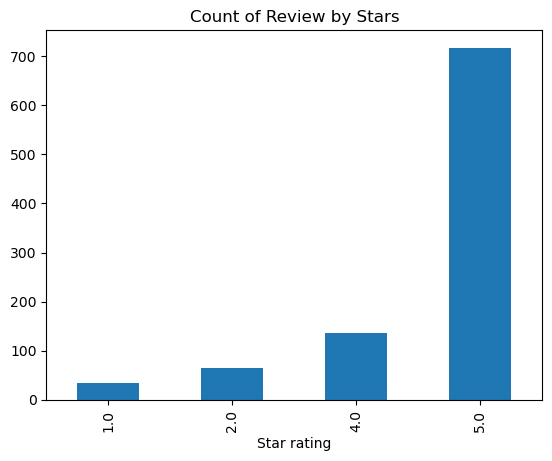

In [6]:
# visualize data distribution
ax = df['star_rating'].value_counts().sort_index().plot(kind='bar', title='Count of Review by Stars')
ax.set_xlabel('Star rating')
plt.show()

### Step 2 - run pipeline

In [6]:
def pipeline_eval(pipe, data, positive_label, negative_label):
  res_dict = {}
  correct = [0 for _ in range(2)]
  total = [0 for _ in range(2)]

  start_time = time.time()
  for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
      text = row['review_body']
      result = pipe(text)[0]
      result['Id'] = row['Id']
      res_dict[i] = result
      if row['star_rating'] < 3.0:
        total[0] += 1
        if result['label'] == negative_label:
          correct[0] += 1
      elif row['star_rating'] > 3.0:
        total[1] += 1
        if result['label'] == positive_label:
          correct[1] += 1
    except RuntimeError:
      print(f'{i}th row broke. The input text is too long.')
      print(IndexError)
    except IndexError:
      print(f'{i}th row broke. The input text is too long.')
      print(IndexError)
  end_time = time.time()
  runtime = end_time - start_time
  return res_dict, correct, total, runtime

In [10]:
!nvidia-smi

Tue Mar 12 15:12:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:C1:00.0 Off |                    0 |
| N/A   31C    P0              48W / 400W |  40260MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

#### Bert Pipeline

In [16]:
pipe_bert = pipeline("text-classification", model="fabriceyhc/bert-base-uncased-amazon_polarity", device=0)

In [17]:
# output example
example = df['review_body'][0]
pipe_bert(example)

[{'label': 'positive', 'score': 0.9992735981941223}]

In [18]:
# evaluate the dataset with BERT
bert_res, bert_correct, bert_total, bert_runtime = pipeline_eval(pipe_bert, df, 'positive', 'negative')

  0%|          | 0/953 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1932 > 512). Running this sequence through the model will result in indexing errors


76th row broke. The input text is too long.
<class 'IndexError'>
101th row broke. The input text is too long.
<class 'IndexError'>
209th row broke. The input text is too long.
<class 'IndexError'>
295th row broke. The input text is too long.
<class 'IndexError'>
330th row broke. The input text is too long.
<class 'IndexError'>
368th row broke. The input text is too long.
<class 'IndexError'>
616th row broke. The input text is too long.
<class 'IndexError'>
622th row broke. The input text is too long.
<class 'IndexError'>
660th row broke. The input text is too long.
<class 'IndexError'>
707th row broke. The input text is too long.
<class 'IndexError'>
708th row broke. The input text is too long.
<class 'IndexError'>
721th row broke. The input text is too long.
<class 'IndexError'>
777th row broke. The input text is too long.
<class 'IndexError'>
812th row broke. The input text is too long.
<class 'IndexError'>
818th row broke. The input text is too long.
<class 'IndexError'>
863th row b

In [62]:
# calculate the accuracy
print(f'==> Negative Accuracy: {bert_correct[0]/bert_total[0]}')
print(f'==> Positive Accuracy: {bert_correct[1]/bert_total[1]}')
print(f'==> Total Accuracy: {np.sum(bert_correct) / np.sum(bert_total)}')
print(f'==> Total Runtime: {bert_runtime}')

==> Negative Accuracy: 0.9696969696969697
==> Positive Accuracy: 0.9260143198090692
==> Total Accuracy: 0.9306296691568837
==> Total Runtime: 12.868469476699829


#### DistilBert Pipeline

In [20]:
pipe_distilbert = pipeline("text-classification", model="AdamCodd/distilbert-base-uncased-finetuned-sentiment-amazon")

In [23]:
pipe_distilbert.model.num_parameters()

66955010

In [20]:
# output example
example = df['review_body'][787]
print(example)
pipe_distilbert(example)

It is not the most creative work but it is certainly interesting.  I think, the movie, however, was horrible.  How would anybody who didn't read the book be able to understand the movie.  No one in a million years would be able to make the connection that the black slab that appears on Earth 3 million years ago is what gave early man the idea of using bone fragments as a mean for hunting for food.  The book is definitely 10 times better than the movie.    If anybody has a comment or anything to say of interest feel free to email me at vpatel@flinet.com


[{'label': 'positive', 'score': 0.8007069826126099}]

In [21]:
# evaluate the dataset on DistilBert
distilbert_res, distilbert_correct, distilbert_total, distilbert_runtime = pipeline_eval(pipe_distilbert, df, 'positive', 'negative')

  0%|          | 0/953 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1932 > 512). Running this sequence through the model will result in indexing errors


76th row broke. The input text is too long.
<class 'IndexError'>
101th row broke. The input text is too long.
<class 'IndexError'>
209th row broke. The input text is too long.
<class 'IndexError'>
295th row broke. The input text is too long.
<class 'IndexError'>
330th row broke. The input text is too long.
<class 'IndexError'>
368th row broke. The input text is too long.
<class 'IndexError'>
616th row broke. The input text is too long.
<class 'IndexError'>
622th row broke. The input text is too long.
<class 'IndexError'>
660th row broke. The input text is too long.
<class 'IndexError'>
707th row broke. The input text is too long.
<class 'IndexError'>
708th row broke. The input text is too long.
<class 'IndexError'>
721th row broke. The input text is too long.
<class 'IndexError'>
777th row broke. The input text is too long.
<class 'IndexError'>
812th row broke. The input text is too long.
<class 'IndexError'>
818th row broke. The input text is too long.
<class 'IndexError'>
863th row b

In [22]:
# calculate the accuracy
print(f'==> Negative Accuracy: {distilbert_correct[0]/distilbert_total[0]}')
print(f'==> Positive Accuracy: {distilbert_correct[1]/distilbert_total[1]}')
print(f'==> Total Accuracy: {np.sum(distilbert_correct) / np.sum(distilbert_total)}')
print(f'==> Total Runtime: {distilbert_runtime}')

==> Negative Accuracy: 0.9090909090909091
==> Positive Accuracy: 0.9630071599045346
==> Total Accuracy: 0.9573105656350054
==> Total Runtime: 7.052353382110596


#### GPT2 Pipeline


In [23]:
pipe_gpt2 = pipeline("text-classification", model="mnoukhov/gpt2-imdb-sentiment-classifier")

config.json:   0%|          | 0.00/995 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

In [24]:
# output example
example = df['review_body'][102]
print(example)
pipe_gpt2(example)

Hey, I'm female and I loved this book.  I thought it was very funny and actually quite sweet.  Sure, the guy was kind of a dope, but aren't we all?? (women included!


[{'label': 'LABEL_1', 'score': 0.9998786449432373}]

In [25]:
# evaluate the dataset on GPT2
gpt2_res, gpt2_correct, gpt2_total, gpt2_runtime = pipeline_eval(pipe_gpt2, df, 'LABEL_1', 'LABEL_0')

  0%|          | 0/953 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2064 > 1024). Running this sequence through the model will result in indexing errors


76th row broke. The input text is too long.
<class 'IndexError'>
812th row broke. The input text is too long.
<class 'IndexError'>


In [26]:
# calculate the accuracy
print(f'==> Negative Accuracy: {gpt2_correct[0]/gpt2_total[0]}')
print(f'==> Positive Accuracy: {gpt2_correct[1]/gpt2_total[1]}')
print(f'==> Total Accuracy: {np.sum(gpt2_correct) / np.sum(gpt2_total)}')
print(f'==> Total Runtime: {gpt2_runtime}')

==> Negative Accuracy: 0.8888888888888888
==> Positive Accuracy: 0.931924882629108
==> Total Accuracy: 0.9274447949526814
==> Total Runtime: 69.748037815094


#### Roberta Pipeline

In [27]:
pipe_roberta = pipeline("text-classification", model="siebert/sentiment-roberta-large-english", device = 0)

In [28]:
# output example
example = df['review_body'][93]
print(example)
pipe_roberta(example)

I was checking on this book because I just recommended it as an acquisition for the library at the community colllege where I teach.  The book describes the life of a brilliant Nobel Prize-winning physicist, and shows him as a completely accessible human being.  He gives a marvelously entertaining account of some of the experiments he conducted while a college undergraduate - all of them completely understandable to a layperson.  But the book continues through his adult life: his attempts to learn Japanese, his experiences as a patron and legal defender of a local strip club, his encounters with military stuffed shirts during WWII, and dozens of other adventures.  If you want to convince yourself or someone else that it's possible to be a brilliant scientist and a real human being simultaneously, then this is the book.  Both as entertainment and as information, it's a smashing success


[{'label': 'POSITIVE', 'score': 0.9989196062088013}]

In [29]:
# evaluate the dataset on Roberta
roberta_res, roberta_correct, roberta_total, roberta_runtime = pipeline_eval(pipe_roberta, df, 'POSITIVE', 'NEGATIVE')

  0%|          | 0/953 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2066 > 512). Running this sequence through the model will result in indexing errors


76th row broke. The input text is too long.
<class 'IndexError'>
101th row broke. The input text is too long.
<class 'IndexError'>
209th row broke. The input text is too long.
<class 'IndexError'>
295th row broke. The input text is too long.
<class 'IndexError'>
330th row broke. The input text is too long.
<class 'IndexError'>
368th row broke. The input text is too long.
<class 'IndexError'>
616th row broke. The input text is too long.
<class 'IndexError'>
622th row broke. The input text is too long.
<class 'IndexError'>
660th row broke. The input text is too long.
<class 'IndexError'>
707th row broke. The input text is too long.
<class 'IndexError'>
708th row broke. The input text is too long.
<class 'IndexError'>
721th row broke. The input text is too long.
<class 'IndexError'>
776th row broke. The input text is too long.
<class 'IndexError'>
777th row broke. The input text is too long.
<class 'IndexError'>
785th row broke. The input text is too long.
<class 'IndexError'>
812th row b

In [30]:
# calculate the accuracy
print(f'==> Negative Accuracy: {roberta_correct[0]/roberta_total[0]}')
print(f'==> Positive Accuracy: {roberta_correct[1]/roberta_total[1]}')
print(f'==> Total Accuracy: {np.sum(roberta_correct) / np.sum(roberta_total)}')
print(f'==> Total Runtime: {roberta_runtime}')

==> Negative Accuracy: 0.9591836734693877
==> Positive Accuracy: 0.961768219832736
==> Total Accuracy: 0.9614973262032086
==> Total Runtime: 26.068453311920166


#### Electra Pipeline

In [24]:
pipe_electra = pipeline("text-classification", model="pig4431/amazonPolarity_ELECTRA_5E")

In [25]:
pipe_electra.model.num_parameters()

109483778

In [9]:
# output example
example = df['review_body'][93]
print(example)
pipe_electra(example)

I was checking on this book because I just recommended it as an acquisition for the library at the community colllege where I teach.  The book describes the life of a brilliant Nobel Prize-winning physicist, and shows him as a completely accessible human being.  He gives a marvelously entertaining account of some of the experiments he conducted while a college undergraduate - all of them completely understandable to a layperson.  But the book continues through his adult life: his attempts to learn Japanese, his experiences as a patron and legal defender of a local strip club, his encounters with military stuffed shirts during WWII, and dozens of other adventures.  If you want to convince yourself or someone else that it's possible to be a brilliant scientist and a real human being simultaneously, then this is the book.  Both as entertainment and as information, it's a smashing success


[{'label': 'LABEL_1', 'score': 0.9992049336433411}]

In [13]:
# evaluate the dataset on Electra
electra_res, electra_correct, electra_total, electra_runtime = pipeline_eval(pipe_electra, df, 'LABEL_1', 'LABEL_0')

  0%|          | 0/953 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1932 > 512). Running this sequence through the model will result in indexing errors


76th row broke. The input text is too long.
<class 'IndexError'>
101th row broke. The input text is too long.
<class 'IndexError'>
209th row broke. The input text is too long.
<class 'IndexError'>
295th row broke. The input text is too long.
<class 'IndexError'>
330th row broke. The input text is too long.
<class 'IndexError'>
368th row broke. The input text is too long.
<class 'IndexError'>
616th row broke. The input text is too long.
<class 'IndexError'>
622th row broke. The input text is too long.
<class 'IndexError'>
660th row broke. The input text is too long.
<class 'IndexError'>
707th row broke. The input text is too long.
<class 'IndexError'>
708th row broke. The input text is too long.
<class 'IndexError'>
721th row broke. The input text is too long.
<class 'IndexError'>
777th row broke. The input text is too long.
<class 'IndexError'>
812th row broke. The input text is too long.
<class 'IndexError'>
818th row broke. The input text is too long.
<class 'IndexError'>
863th row b

In [14]:
# calculate the accuracy
print(f'==> Negative Accuracy: {electra_correct[0]/electra_total[0]}')
print(f'==> Positive Accuracy: {electra_correct[1]/electra_total[1]}')
print(f'==> Total Accuracy: {np.sum(electra_correct) / np.sum(electra_total)}')
print(f'==> Total Runtime: {electra_runtime}')

==> Negative Accuracy: 0.9494949494949495
==> Positive Accuracy: 0.9582338902147971
==> Total Accuracy: 0.9573105656350054
==> Total Runtime: 58.141876459121704


### Step 3 - results evaluation


> experiment results on 1000 rows(ignore star_rating==3) of amazon reviews






|Model|Bert|DistilBert|GPT2|Roberta|Electra|
|-|-|-|-|-|-|
|Accuracy|0.931|0.957|0.927|**0.961**|0.9573|
|Runtime(GPU)/s|23.34|**14.03**|-|64.72|12.39|
|Runtime(CPU)/s|408.1|**168.5**|397.4|1173.81|58.14|


> combine the results from 4 NLP models

In [31]:
results_df = df.copy()

# merge bert results
bert_df = pd.DataFrame(bert_res).T
bert_df = bert_df.rename(columns={'label':'bert_label', 'score':'bert_score'})
results_df = bert_df.merge(results_df, on='Id', how='right')

# merge distilbert results
distilbert_df = pd.DataFrame(distilbert_res).T
distilbert_df = distilbert_df.rename(columns={'label':'distilbert_label', 'score':'distilbert_score'})
results_df = distilbert_df.merge(results_df, on='Id', how='right')

# merge gpt2 results
gpt2_df = pd.DataFrame(gpt2_res).T
gpt2_df = gpt2_df.rename(columns={'label':'gpt2_label', 'score':'gpt2_score'})
results_df = gpt2_df.merge(results_df, on='Id', how='right')

# merge roberta results
roberta_df = pd.DataFrame(roberta_res).T
roberta_df = roberta_df.rename(columns={'label':'roberta_label', 'score':'roberta_score'})
results_df = roberta_df.merge(results_df, on='Id', how='right')

# merge electra results
electra_df = pd.DataFrame(electra_res).T
electra_df = electra_df.rename(columns={'label':'electra_label', 'score':'electra_score'})
results_df = electra_df.merge(results_df, on='Id', how='right')

results_df

,electra_label,electra_score,Id,roberta_label,roberta_score,gpt2_label,gpt2_score,distilbert_label,distilbert_score,bert_label,bert_score,star_rating,review_headline,review_body
0,LABEL_1,0.999072,0,POSITIVE,0.998651,LABEL_1,0.995611,positive,0.940794,positive,0.999274,4.0,ignore the review below,this is the first 8 issues of the series. it i...
1,LABEL_1,0.999138,1,POSITIVE,0.998186,LABEL_1,0.692617,positive,0.93976,positive,0.997928,4.0,awesome,I've always been partial to immutable laws. Th...
2,LABEL_1,0.999112,2,POSITIVE,0.998927,LABEL_1,0.998892,positive,0.985596,positive,0.999536,5.0,Read the book. It's good.,This is a book about first contact with aliens...
3,LABEL_1,0.998181,3,POSITIVE,0.998828,LABEL_1,0.99923,positive,0.995864,positive,0.999416,5.0,Funniest book ever written about the Anti-Christ,This is quite possibly *the* funniest book I h...
4,LABEL_1,0.997729,4,POSITIVE,0.995492,LABEL_1,0.921034,positive,0.962026,positive,0.991981,5.0,A winner that didn't last. Only a mothers love...,The story behind the book is almost better tha...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,LABEL_0,0.999799,995,NEGATIVE,0.999511,LABEL_0,0.977122,negative,0.999526,negative,0.999783,2.0,"well, maybe I should try it again","It has been a long, long time since I didn't f..."
949,LABEL_1,0.997758,996,POSITIVE,0.998879,LABEL_1,0.999413,positive,0.994697,positive,0.999126,5.0,An enjoyable read!,Scarpetta remains one of the most compelling c...
950,LABEL_1,0.99931,997,POSITIVE,0.998885,LABEL_1,0.998895,positive,0.995815,positive,0.999779,5.0,If You Have to Pick One Book for Your Students...,I am a college professor. I have been having ...
951,LABEL_1,0.99912,998,POSITIVE,0.998934,LABEL_1,0.999746,positive,0.993745,positive,0.999837,5.0,This is for anyone who loves literature,"This is a book to the heart, with the wisdom o..."


> bert model failure cases

In [91]:
# False Positive
fp = results_df.query('star_rating in (1.0,2.0) and bert_label == "positive"')

# False Negative
fn = results_df.query('star_rating in (5.0,4.0) and bert_label == "negative"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: Disappointing 
 Enjoyed the book.  Hated the ending

===> False Negative:
 title: The infamous classic of modern fiction. 
 Burgess himself has criticized and attacked this novel which he published in 1968, but which has come to be regarded alongside such dystopian classics as _Brave New World_ and,  perhaps more appropriately, Yevgeny Zamyatin's _We_. An  unsparing story of a sociopathic hoodlum, Alex, _A Clockwork  Orange_ is shocking and often a difficult read despite the  bizarre and sometimes surreal street language employed by  its narrator, a dialect of some archaic words, a few   neologisms, and a great deal of Anglicized Russian. The   film by Stanley Kubrick is equally disturbing, but, as   Burgess himself notes in the introduction to this edition,  leaves off the crucial twenty-first chapter, a chapter that  is vital to the book both for its numerical significance  (twenty-one being considered the age of maturity), and its  philosophical poignanc

> distilbert model failure cases

In [92]:
# False Positive
fp = results_df.query('star_rating in (1.0,2.0) and distilbert_label == "positive"')

# False Negative
fn = results_df.query('star_rating in (5.0,4.0) and distilbert_label == "negative"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: Grisham needs a co-author 
 The Client again demonstrates that success is built upon the abysmally low standards of the American reader and the resonance engendered in that public by detailing the slime of the American legal system. The book is a tour de force of weaving together a cast of cartoon characters, farcical plot  and a No Henry ending by means of talented prose. The guy can write but he demonstratively lacks anything to write about. Grisham's motto appears to be: Suspend any rational though when you read this book.<br /><br />His books fall into two classes: 1) Hate &quot;whitey&quot; polemics and 2) Action-Suspense without suspense but with random action.<br /> He would please me if he would join forces with another writer who had a head for story line, character development and had a logical mind. With such help, a future Grisham novel could make sense as well as have great surging prose style.

===> False Negative:
 title: An excellent treatis

> GPT2 model failure cases

In [93]:
# False Positive
fp = results_df.query('star_rating in (1.0,2.0) and gpt2_label == "LABEL_1"')

# False Negative
fn = results_df.query('star_rating in (5.0,4.0) and gpt2_label == "LABEL_0"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: Evil Triumphs Over Evil:  Who Cares? 
 An entertaining enough potboiler, but the characters are all sodespicable I found myself hoping they all lost.  This book makes oneappreciate how much better the legal suspense genre is currently being written by others, especially Scott Turow.

===> False Negative:
 title: Excellent historical fiction, well written 
 It really happened: only the names have been changed...<BR>  Yoshi Toranaga was Tokugawa Ieyasu, the founder of the  Tokugawa Shogunate. There really was a Battle of Sekigahara,    although Ishido (Ishida Mitsunari) was beheaded, not buried   while passers-by sawed at his neck... Toda Buntaro   (Lord Hosokawa) had a Christian wife, Gracia (who appears   in the story as Mariko). The Taiko was Toyotomi Hideyoshi,   and he really did order an invasion of Korea. The dictator   Goroda was Oda Nobunaga, and he was a nasty S.O.B., even   by daimyo standards. <br />   [...] &quot;The Crisis Manager&quot;

===> To

> Roberta model failure cases

In [94]:
# False Positive
fp = results_df.query('star_rating in (1.0,2.0) and roberta_label == "POSITIVE"')

# False Negative
fn = results_df.query('star_rating in (5.0,4.0) and roberta_label == "NEGATIVE"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: an absorbing portrayal of interior thought. 
 I found Albert Cohen's magnum opus \\"Belle due Seigneur\\" a very personal, idiosyncratic display of the workings of the internal dialogue. If nothing else, Mr. Cohen has caught the stuttering, semi-incoherent lilt of the person talking to themselves. His pacing is that of a daytime soap opera, and the internal chatter makes it very compelling and oddly reminiscent of Dune (Herbert Marshall).   Criticisms would include a cynical tone so profound that it becomes limiting.

===> False Negative:
 title: The plot was good, but at the same time it was perverted 
 I thought that the main idea of this was very good.  In the beginning it was very stupid though.  I don't really care that these people want to get a look at Boo Radley.  That is so stupid.  However towards the end, teh trail and the action sfollowing were very good.  This book was perverted though.  The author of this book was sick, I am sorry to say

===>

> Electra model failure cases

In [33]:
# False Positive
fp = results_df.query('star_rating in (1.0,2.0) and electra_label == "LABEL_1"')

# False Negative
fn = results_df.query('star_rating in (5.0,4.0) and electra_label == "LABEL_0"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: Clarke too old to write new words 
 <br />Have read all the books in this series, and literally got to read them again in this one. Clarke is one of the few authors in the world unafraid to plaigiarize himself.  Several of the chapters of this extremely slim volume are word-for-word lifts from the other books.<br />If your memory is bad or this is the first work of Clarke's that you've ever picked up, then you'll probably enjoy this little read, but I'd wait until it comes out in paperback if I were you

===> False Negative:
 title: Horror creeps upon you like a cold wind 
 Ten Strangers on a cold, isolated island.  Brought here by a queerly anonymous invitation.<br /><br />The evening begins with light conversation and witticisms.  But it soon degenerates into beastly fear and mistrust.  One by one, each of the 10 are being found murdered.  And the murdered is clearly one of the 10...but which one?<br /><br /> Every turn of the page is like stumbling throu

## Traditional NLP model Baseline on [Amazon Polarity Dataset](https://huggingface.co/datasets/amazon_polarity)

### Step 1 - Dataset Loading

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00


In [13]:
# run this when you have not downloaded the dataset
from datasets import load_dataset

dataset = load_dataset("amazon_polarity", cache_dir="../data/capstone/amazon_polarity")
# dataset.save_to_disk('drive/MyDrive/Capstone/') # change the path to the local path

In [ ]:
# run this when you have already downloaded and save the dataset
from datasets import load_from_disk
dataset = load_from_disk('../data/capstone/amazon_polarity')

In [14]:
# example
print(len(dataset['test']))
print(dataset['test'][0])

400000
{'label': 1, 'title': 'Great CD', 'content': 'My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"'}


### Step 2 - run pipeline

In [15]:
def pipeline_eval2(pipe, data, positive_label, negative_label, maxlen = 40000):
  res_dict = {}
  correct = [0 for _ in range(2)]
  total = [0 for _ in range(2)]

  start_time = time.time()
  for i, row in tqdm(enumerate(data), total=maxlen):
    if i > maxlen:
      break
    try:
      text = row['content']
      result = pipe(text)[0]
      res_dict[i] = result
      if row['label'] == 0:
        total[0] += 1
        if result['label'] == negative_label:
          correct[0] += 1
      elif row['label'] == 1:
        total[1] += 1
        if result['label'] == positive_label:
          correct[1] += 1
    except RuntimeError:
      print(f'{i}th row broke. The input text is too long.')
    except IndexError:
      print(f'{i}th row broke. The input text is too long.')
  end_time = time.time()
  runtime = end_time - start_time
  return res_dict, correct, total, runtime

In [5]:
from transformers import pipeline
import numpy as np
import time

/home/xiao.yang3/.conda/envs/llama2/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [6]:
dataset['test'][40000]

{'label': 0,
 'title': "If I didn't have to choose at least one star I would give this film negative 1000",
 'content': "I hate this movie. It truly is that clear cut. What do people see that isn't there. What isn't there precisely, you ask? Well, an innovative plot, quality acting, quality filmwork, a unique script, and something worth my time.Everyone reading the hails and praises of this film must recall that the people writing these responses are emotionally void and none too film savvy. It takes little more than taking off a pair of rose colored glasses to see the stink festering underneath this crapheap of a film.Fear Zach Braff. Fear."}

#### Bert Pipeline

In [19]:
pipe_bert = pipeline("text-classification", model="fabriceyhc/bert-base-uncased-amazon_polarity", device=0)

/home/xiao.yang3/.conda/envs/llama2/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [20]:
# evaluate the test set with BERT
bert_res, bert_correct, bert_total, bert_runtime = pipeline_eval2(pipe_bert, dataset['test'], 'positive', 'negative')

  0%|          | 0/40000 [00:00<?, ?it/s]

/home/xiao.yang3/.conda/envs/llama2/lib/python3.11/site-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [21]:
# calculate the accuracy
print(f'==> Negative Accuracy: {bert_correct[0]/bert_total[0]}')
print(f'==> Positive Accuracy: {bert_correct[1]/bert_total[1]}')
print(f'==> Total Accuracy: {np.sum(bert_correct) / np.sum(bert_total)}')
print(f'==> Total Runtime: {bert_runtime}')

==> Negative Accuracy: 0.9509724060686284
==> Positive Accuracy: 0.9357532295299377
==> Total Accuracy: 0.9432264193395166
==> Total Runtime: 270.15666127204895


#### DistilBert Pipeline

In [10]:
pipe_distilbert = pipeline("text-classification", model="AdamCodd/distilbert-base-uncased-finetuned-sentiment-amazon", device = 0)

In [11]:
# evaluate the dataset on DistilBert
distilbert_res, distilbert_correct, distilbert_total, distilbert_runtime = pipeline_eval2(pipe_distilbert, dataset['test'], 'positive', 'negative')

  0%|          | 0/40000 [00:00<?, ?it/s]

In [15]:
# calculate the accuracy
print(f'==> Negative Accuracy: {distilbert_correct[0]/distilbert_total[0]}')
print(f'==> Positive Accuracy: {distilbert_correct[1]/distilbert_total[1]}')
print(f'==> Total Accuracy: {np.sum(distilbert_correct) / np.sum(distilbert_total)}')
print(f'==> Total Runtime: {distilbert_runtime}')

==> Negative Accuracy: 0.9332043580083494
==> Positive Accuracy: 0.9512255022348839
==> Total Accuracy: 0.9423764405889853
==> Total Runtime: 288.0517086982727


#### GPT2 Pipeline

In [13]:
pipe_gpt2 = pipeline("text-classification", model="mnoukhov/gpt2-imdb-sentiment-classifier")

In [14]:
# evaluate the dataset on GPT2
gpt2_res, gpt2_correct, gpt2_total, gpt2_runtime = pipeline_eval2(pipe_gpt2, dataset['test'], 'LABEL_1', 'LABEL_0')

  0%|          | 0/40000 [00:00<?, ?it/s]

In [16]:
# calculate the accuracy
print(f'==> Negative Accuracy: {gpt2_correct[0]/gpt2_total[0]}')
print(f'==> Positive Accuracy: {gpt2_correct[1]/gpt2_total[1]}')
print(f'==> Total Accuracy: {np.sum(gpt2_correct) / np.sum(gpt2_total)}')
print(f'==> Total Runtime: {gpt2_runtime}')

==> Negative Accuracy: 0.8825985133896752
==> Positive Accuracy: 0.9389950390490692
==> Total Accuracy: 0.9113022174445639
==> Total Runtime: 1831.1833262443542


#### Roberta Pipeline

In [17]:
pipe_roberta = pipeline("text-classification", model="siebert/sentiment-roberta-large-english", device = 0)

In [19]:
# evaluate the dataset on Roberta
roberta_res, roberta_correct, roberta_total, roberta_runtime = pipeline_eval2(pipe_roberta, dataset['test'], 'POSITIVE', 'NEGATIVE')

  0%|          | 0/40000 [00:00<?, ?it/s]

In [20]:
# calculate the accuracy
print(f'==> Negative Accuracy: {roberta_correct[0]/roberta_total[0]}')
print(f'==> Positive Accuracy: {roberta_correct[1]/roberta_total[1]}')
print(f'==> Total Accuracy: {np.sum(roberta_correct) / np.sum(roberta_total)}')
print(f'==> Total Runtime: {roberta_runtime}')

==> Negative Accuracy: 0.9447103146319112
==> Positive Accuracy: 0.9630139004862714
==> Total Accuracy: 0.9540261493462664
==> Total Runtime: 1004.050708770752


### Step 3 - results evaluation

> experiment results on 40000 rows from amazon polarity test set




|Model|Bert|DistilBert|GPT2|Roberta|
|-|-|-|-|-|
|Accuracy|0.943|0.942|0.911|**0.954**|
|Runtime(GPU)/s|516.14|**288.05**|-|1004.05|
|Runtime(CPU)/s|||1831.18||


> combine the results from 4 NLP models

In [32]:
results_df = pd.DataFrame(dataset['test'][:40000])
results_df = results_df.reset_index().rename(columns={'index':'Id', 'title':'review_headline', 'content': 'review_body'})
results_df.head(100)

,Id,label,review_headline,review_body
0,0,1,Great CD,My lovely Pat has one of the GREAT voices of h...
1,1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...
...,...,...,...,...
95,95,1,The Scarlet Letter a must read for any American,The best book that I have ever been assigned t...
96,96,0,The Scarlet Letter: A soap opera,"Although this book, is considered a great work..."
97,97,1,This book is Great!,One might notice that many of the negative rev...
98,98,0,I had to read it...,I had to read this book for school. I did not ...


In [33]:
# merge bert results
bert_df = pd.DataFrame(bert_res).T
bert_df = bert_df.reset_index().rename(columns={'index':'Id', 'label':'bert_label', 'score':'bert_score'})
results_df = bert_df.merge(results_df, on='Id', how='right')

# merge distilbert results
distilbert_df = pd.DataFrame(distilbert_res).T
distilbert_df = distilbert_df.reset_index().rename(columns={'index':'Id','label':'distilbert_label', 'score':'distilbert_score'})
results_df = distilbert_df.merge(results_df, on='Id', how='right')

# merge gpt2 results
gpt2_df = pd.DataFrame(gpt2_res).T
gpt2_df = gpt2_df.reset_index().rename(columns={'index':'Id', 'label':'gpt2_label', 'score':'gpt2_score'})
results_df = gpt2_df.merge(results_df, on='Id', how='right')

# merge roberta results
roberta_df = pd.DataFrame(roberta_res).T
roberta_df = roberta_df.reset_index().rename(columns={'index':'Id', 'label':'roberta_label', 'score':'roberta_score'})
results_df = roberta_df.merge(results_df, on='Id', how='right')

results_df.head(100)

,Id,roberta_label,roberta_score,gpt2_label,gpt2_score,distilbert_label,distilbert_score,bert_label,bert_score,label,review_headline,review_body
0,0,POSITIVE,0.998855,LABEL_1,0.923132,positive,0.997834,positive,0.999375,1,Great CD,My lovely Pat has one of the GREAT voices of h...
1,1,POSITIVE,0.998923,LABEL_1,0.99978,positive,0.998908,positive,0.999857,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,2,NEGATIVE,0.999497,LABEL_0,0.875909,negative,0.999329,negative,0.999672,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,3,POSITIVE,0.998713,LABEL_1,0.933973,positive,0.726695,positive,0.994726,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,4,POSITIVE,0.998811,LABEL_1,0.885195,positive,0.933509,positive,0.993844,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,POSITIVE,0.998883,LABEL_1,0.999897,positive,0.998502,positive,0.999853,1,The Scarlet Letter a must read for any American,The best book that I have ever been assigned t...
96,96,NEGATIVE,0.999515,LABEL_0,0.996421,negative,0.999293,negative,0.999907,0,The Scarlet Letter: A soap opera,"Although this book, is considered a great work..."
97,97,POSITIVE,0.997052,LABEL_1,0.969493,positive,0.663248,positive,0.982679,1,This book is Great!,One might notice that many of the negative rev...
98,98,NEGATIVE,0.999506,LABEL_0,0.954108,negative,0.998617,negative,0.999576,0,I had to read it...,I had to read this book for school. I did not ...


> bert model failure cases

In [35]:
# False Positive
fp = results_df.query('label == 0 and bert_label == "positive"')

# False Negative
fn = results_df.query('label == 1 and bert_label == "negative"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: A historical gem whose title obscures its intent 
 Started laughing in the second chapter....enjoyed the book after I realized that I wasn't going to learn anything new. It's obviously a miracle that we survived for the 65 years since it was first published.And seeing that the pending insolvency of the US was as loudly shouted in the 40's as it is now was worth the price. This book had quotes that would shame both modern day political extremes in the US.Kudos to whoever owns the copyright --- now there's economics in action.

===> False Negative:
 title: I recommend ordering a size or 2 larger than your regular size. 
 I ordered the Squeem waist shaper in a size small...my general size is 4-6, I'm 5'4 and weigh 120lbs right now; over the winter I ate too much cheese and gained about 7 lbs which isn't much to complain about but I have a roll of belly fat that shows through a slinky dress (I just wanted to smooth out my middle and fat above my hips). I wish I

> distilbert model failure cases

In [36]:
# False Positive
fp = results_df.query('label == 0 and distilbert_label == "positive"')

# False Negative
fn = results_df.query('label == 1 and distilbert_label == "negative"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: Had to return it 
 The sizing is perfect and a medium fits just right. I am 5'2 size 4 137 lbs before baby and i gained about 35 lbs during pregnancy, just an idea for sizing but keepin mind that everyone has different fat distributions on their bodies. I don't like how my post baby fat was getting pushed up the top and makes me look like I have back boobs. The shape wear crunched up after you sit or bent over and so it doesn't feel smooth all over. Squeem makes a vest version too so maybe that one will be a better choice for better coverage. If you do decide to purchase this product it's easier to squeeze in if you lay on your bed and suck in your guts.

===> False Negative:
 title: Sassy Baby Warming Dish. Interesting concept. 
 We tried the Baby warming dish. We found that for our 1 year old it was pretty small, and didn't really hold enough water to keep her warm.I think it would work ok for an infant, although I think a blanket would work just as well.

In [38]:
# False Positive
fp = results_df.query('label == 0 and gpt2_label == "LABEL_1"')

# False Negative
fn = results_df.query('label == 1 and gpt2_label == "LABEL_0"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: A historical gem whose title obscures its intent 
 Started laughing in the second chapter....enjoyed the book after I realized that I wasn't going to learn anything new. It's obviously a miracle that we survived for the 65 years since it was first published.And seeing that the pending insolvency of the US was as loudly shouted in the 40's as it is now was worth the price. This book had quotes that would shame both modern day political extremes in the US.Kudos to whoever owns the copyright --- now there's economics in action.

===> False Negative:
 title: Great Beginning...poor ending 
 Parricia Corwell, Cruel & Unusual was breathtaking in the beginning! Her relation to her family, her dedication to her work exeptional. However, this story began to get boring towards the end...the ending, not too great.

===> Total False Positive: 2306
===> Total False Negative: 1242


In [39]:
# False Positive
fp = results_df.query('label == 0 and roberta_label == "POSITIVE"')

# False Negative
fn = results_df.query('label == 1 and roberta_label == "NEGATIVE"')
if len(fp) > 0:
    print(f'===> False Positive:\n title: {fp["review_headline"].values[2]} \n {fp["review_body"].values[2]}\n')
if len(fn) > 0:
    print(f'===> False Negative:\n title: {fn["review_headline"].values[2]} \n {fn["review_body"].values[2]}\n')
print(f'===> Total False Positive: {len(fp)}')
print(f'===> Total False Negative: {len(fn)}')

===> False Positive:
 title: Broke the 2nd time I wore it, great until then 
 I think this product provided a great fit. I was able to hook on the first row by myself within about 5 mins max. It wasn't quite as difficult to get on as I thought it might be, although it isn't particularly easy either. I tried it on and wore for about 2 hours, and then the 2nd time I wore it had it on for about the same period of time. I took it off and one of the metal boning pieces had popped through and was hanging out at the bottom. This product is far too expensive to have something like that happen. The fit on me was snug, but I am sure I had the correct size. Now I have to figure out how to get this resolved.

===> False Negative:
 title: great book. i loved it! they mentioned a movie, where is it? 
 the publisher said soon to be a movie. does anyone know if a movie was ever created?

===> Total False Positive: 1086
===> Total False Negative: 753


## Zero-shot Sentiment Analysis with Pre-trained LLM

In [2]:
from langchain import HuggingFacePipeline
from transformers import AutoTokenizer
import transformers
import torch
import accelerate
import time

In [19]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Tue Feb 27 20:39:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:81:00.0 Off |                    0 |
| N/A   41C    P0              58W / 400W |  38838MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### define LLM pipeline

In [6]:
def pipeline_eval_llm(pipe, data, template, positive_label, negative_label):
  res_dict = {}
  correct = [0 for _ in range(2)]
  total = [0 for _ in range(2)]

  start_time = time.time()
  for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
      text = row['review_body']
      prompt = template.format(text = text)
      result = pipe(prompt)[0]
      result['Id'] = row['Id']
      res_dict[i] = result
      if row['star_rating'] < 3.0:
        total[0] += 1
        if result['generated_text'] == negative_label:
          correct[0] += 1
      elif row['star_rating'] > 3.0:
        total[1] += 1
        if result['generated_text'] == positive_label:
          correct[1] += 1
    except RuntimeError:
      print(f'{i}th row broke. The input text is too long.')
      print(IndexError)
    except IndexError:
      print(f'{i}th row broke. The input text is too long.')
      print(IndexError)
  end_time = time.time()
  runtime = end_time - start_time
  return res_dict, correct, total, runtime

In [5]:
task_name = 'sentiment classification'
label_space = ['negative', 'positive']
task_definition = f'Given the sentence, assign a sentiment label from {label_space}'
output_format = "Return label only without any other text."

template = f"Please perform {task_name} task.\n{task_definition}\n{output_format}\nSentence:\n" + "{text}."

#### Flan-T5 pipeline

In [3]:
# Flan-T5
pipeFlanT5 = pipeline("text2text-generation", model="google/flan-t5-xxl", device=0)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [28]:
pipeFlanT5.model.num_parameters()

11135332352

In [8]:
example = "Ten Strangers on a cold, isolated island.  Brought here by a queerly anonymous invitation.<br /><br />The evening begins with light conversation and witticisms.  But it soon degenerates into beastly fear and mistrust.  One by one, each of the 10 are being found murdered.  And the murdered is clearly one of the 10...but which one?<br /><br /> Every turn of the page is like stumbling through a dank horror house.  What grisly find waits around the next corner?<br /><br /> You'll never solve this mystery.  It's too cunning.  But you'll relish the goosebumps that sweep over you like a cold sea-wind, and the horror that catches in your throat like poisoned wine."
start_time = time.time()
prompt = template.format(text = example)
output = pipeFlanT5(prompt)
end_time = time.time()
print(f'input : {example}')
print(f'output : {output}')
print(f'runtime : {end_time-start_time}')

input : Ten Strangers on a cold, isolated island.  Brought here by a queerly anonymous invitation.<br /><br />The evening begins with light conversation and witticisms.  But it soon degenerates into beastly fear and mistrust.  One by one, each of the 10 are being found murdered.  And the murdered is clearly one of the 10...but which one?<br /><br /> Every turn of the page is like stumbling through a dank horror house.  What grisly find waits around the next corner?<br /><br /> You'll never solve this mystery.  It's too cunning.  But you'll relish the goosebumps that sweep over you like a cold sea-wind, and the horror that catches in your throat like poisoned wine.
output : [{'generated_text': 'positive'}]
runtime : 0.3011922836303711


In [10]:
# evaluate the dataset with Flan-T5
FlanT5_res, FlanT5_correct, FlanT5_total, FlanT5_runtime = pipeline_eval_llm(pipeFlanT5, df, template, 'positive', 'negative')

  0%|          | 0/953 [00:00<?, ?it/s]

/home/xiao.yang3/.conda/envs/llama2/lib/python3.11/site-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors


In [11]:
# calculate the accuracy
print(f'==> Negative Accuracy: {FlanT5_correct[0]/FlanT5_total[0]}')
print(f'==> Positive Accuracy: {FlanT5_correct[1]/FlanT5_total[1]}')
print(f'==> Total Accuracy: {np.sum(FlanT5_correct) / np.sum(FlanT5_total)}')
print(f'==> Total Runtime: {FlanT5_runtime}')

==> Negative Accuracy: 0.9595959595959596
==> Positive Accuracy: 0.9660421545667447
==> Total Accuracy: 0.9653725078698846
==> Total Runtime: 253.21945691108704


#### Flan-UL2 Pipeline

In [31]:
# flan-UL2
pipeFlanUL2 = pipeline("text2text-generation", model="google/flan-ul2")

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [30]:
del pipeFlanT5

In [32]:
pipeFlanUL2.model.num_parameters()

19459613696

In [40]:
example = "Started laughing in the second chapter....enjoyed the book after I realized that I wasn't going to learn anything new. It's obviously a miracle that we survived for the 65 years since it was first published.And seeing that the pending insolvency of the US was as loudly shouted in the 40's as it is now was worth the price. This book had quotes that would shame both modern day political extremes in the US.Kudos to whoever owns the copyright --- now there's economics in action"
start_time = time.time()
prompt = template.format(text = example)
output = pipeFlanUL2(prompt)
end_time = time.time()
print(f'input : {example}')
print(f'output : {output}')
print(f'runtime : {end_time-start_time}')

input : Started laughing in the second chapter....enjoyed the book after I realized that I wasn't going to learn anything new. It's obviously a miracle that we survived for the 65 years since it was first published.And seeing that the pending insolvency of the US was as loudly shouted in the 40's as it is now was worth the price. This book had quotes that would shame both modern day political extremes in the US.Kudos to whoever owns the copyright --- now there's economics in action
output : [{'generated_text': 'positive'}]
runtime : 16.8248770236969


In [ ]:
# evaluate the dataset with Flan-UL2
FlanUL2_res, FlanUL2_correct, FlanUL2_total, FlanUL2_runtime = pipeline_eval_llm(pipeFlanUL2, df, template, 'positive', 'negative')

  0%|          | 0/953 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2211 > 2048). Running this sequence through the model will result in indexing errors


In [45]:
# calculate the accuracy
print(f'==> Negative Accuracy: {FlanUL2_correct[0]/FlanUL2_total[0]}')
print(f'==> Positive Accuracy: {FlanUL2_correct[1]/FlanUL2_total[1]}')
print(f'==> Total Accuracy: {np.sum(FlanUL2_correct) / np.sum(FlanUL2_total)}')
print(f'==> Total Runtime: {FlanUL2_runtime}')

==> Negative Accuracy: 0.9595959595959596
==> Positive Accuracy: 0.9742388758782201
==> Total Accuracy: 0.9727177334732424
==> Total Runtime: 401.77464628219604


#### results evaluation

|Model|FlanT5|FlanUL2|
|-|-|-|
|Accuracy|0.9653|**0.9727**|
|Runtime(GPU)/s|**253.22**|301.77|
|Runtime(CPU)/s|6479.03|-|

# Review Correlation Analysis

## create fewshot dataset from amazon review data

In [19]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer
from datasets import load_dataset
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import evaluate
import os
import json

In [20]:
# load the tsv data
df = pd.read_csv('../data/capstone/amazon_reviews_multilingual_US_v1_00.tsv', sep='\t', on_bad_lines="skip")
df = df.query('star_rating != 3.0')
df = df.reset_index().rename(columns = {'index': 'Id'})
print(len(df))

6366340


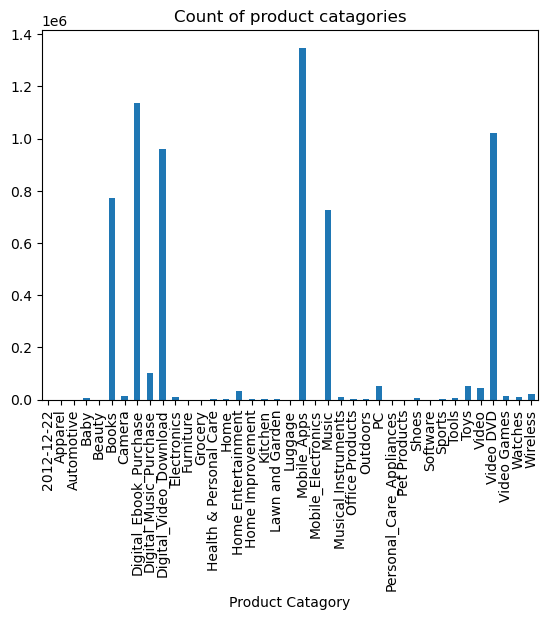

In [17]:
# visualize data distribution
ax = df['product_category'].value_counts().sort_index().plot(kind='bar', title='Count of product catagories')
ax.set_xlabel('Product Catagory')
plt.show()

In [3]:
# find unique product category
products = df['product_category'].unique()
products

array(['Books', 'Music', 'Video', 'Video DVD', 'Toys', 'Tools',
       'Office Products', 'Video Games', 'Software',
       'Digital_Music_Purchase', 'Electronics', 'Digital_Ebook_Purchase',
       'Digital_Video_Download', 'Home Entertainment', 'Kitchen',
       'Camera', 'Outdoors', 'Musical Instruments', 'Sports', 'Watches',
       'PC', 'Home', 'Wireless', 'Beauty', 'Baby', 'Home Improvement',
       'Apparel', 'Shoes', 'Lawn and Garden', 'Mobile_Electronics',
       'Health & Personal Care', 'Luggage', 'Personal_Care_Appliances',
       'Automotive', 'Grocery', 'Mobile_Apps', 'Furniture', '2012-12-22',
       'Pet Products'], dtype=object)

In [24]:
## select 11 products categories 

id2label = {0: "Books", 1: "Music", 2: "Video", 3:"Toys", 4: "Tools", 5: "Office Products", 
            6: "Electronics", 7: "Kitchen", 8: "Sports", 9: "Shoes",
           10: "Health & Personal Care"}

label2id = {"Books": 0, "Music": 1, "Video":2, "Toys": 3, "Tools": 4, "Office Products": 5,
            "Electronics": 6, "Kitchen": 7, "Sports": 8, "Shoes": 9,
           "Health & Personal Care": 10}


In [14]:
# create json file to store data
if not os.path.exists("./amazon_prod_review_cls_train.json") or not os.path.exists("./amazon_prod_review_cls_test.json"):
   data = {'train':[], 'test':[]}
   min_length = 80
   for label in label2id.keys():
       df_i = df.query(f"product_category == '{label}'")
       mask = df_i['review_body'].str.len() > min_length
       df_i = df_i[mask].sample(200)
       df_i = df_i[['Id', 'review_body']].rename(columns = {'review_body': 'text'})
       df_i['label'] = label2id[label]
       df_i_train = df_i[:150]
       df_i_test = df_i[150:]
       data['train'].extend(json.loads(df_i_train.to_json(orient="records")))
       data['test'].extend(json.loads(df_i_test.to_json(orient="records")))
   with open("./amazon_prod_review_cls_train.json", "w") as f:
       json.dump(data['train'], f)
   with open("./amazon_prod_review_cls_test.json", "w") as f:
       json.dump(data['test'], f)
   print('==> train data size:', len(data['train']))
   print('==> test data size:', len(data['test']))

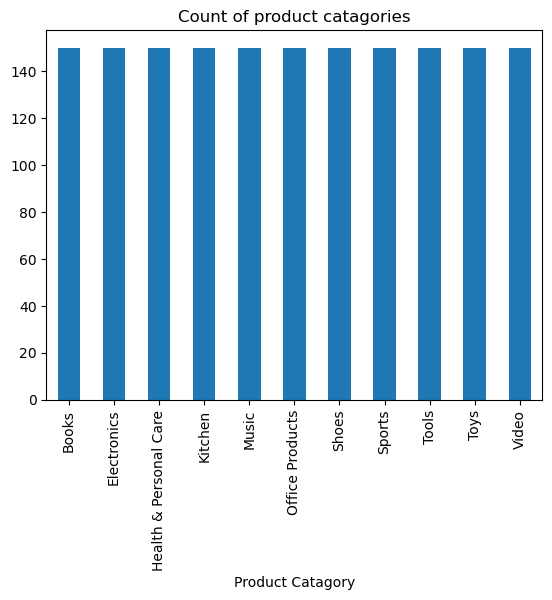

In [37]:
# visualize data distribution
ax = pd.DataFrame(data['train'])['label'].map(id2label).value_counts().sort_index().plot(kind='bar', title='Count of product catagories')
ax.set_xlabel('Product Catagory')
plt.show()

In [5]:
data_files = {
    "train": "amazon_prod_review_cls_train.json",  # train json path
    "test": "amazon_prod_review_cls_test.json"     # test json path
}
dataset = load_dataset("json", data_files=data_files)

train_dataset = dataset['train']
test_dataset = dataset['test']

In [6]:
train_dataset

Dataset({
    features: ['text', 'label', 'Id'],
    num_rows: 1650
})

## SLMs correlation analysis

### define SLM correlation analysis eval pipeline

In [7]:
def pipeline_corr_eval_slm(tokenizer, model, data, id2label):
    res_dict = {}
    correct = [0 for _ in range(11)]
    total = [0 for _ in range(11)]
    preds = []
    labels = []

    start_time = time.time()
    with torch.no_grad():
        for i, row in tqdm(enumerate(data), total=len(data)):
          text = row['text']
          label = int(row['label'])
          token = tokenizer(text, truncation=True, add_special_tokens=True, max_length=512, padding=True, return_tensors="pt")
          logits = model(**token).logits
          pred_cls = logits.argmax(axis=1).item()
          
          res_dict[i] = {'Id': row['Id'], 'pred': id2label[pred_cls]}
          total[label] += 1
          preds.append(pred_cls)
          labels.append(label)
          if pred_cls == label:
              correct[int(label)] += 1

    end_time = time.time()
    runtime = end_time - start_time
    return res_dict, correct, total, runtime, preds, labels

In [8]:
import itertools
classes = ["Books", "Music", "Video", "Toys", "Tools", "Office Products",
            "Electronics", "Kitchen", "Sports", "Shoes",
           "Health & Personal Care"]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### fewshot fine-tuning on distilbert

In [42]:
# create embedding
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, add_special_tokens=True, max_length=512)
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1650 [00:00<?, ? examples/s]

Map:   0%|          | 0/550 [00:00<?, ? examples/s]

In [43]:
max_l = 0
for i in range(600):
    if len(tokenized_train_dataset[i]['input_ids']) > max_l:
        max_l = len(tokenized_train_dataset[i]['input_ids']) 
max_l

512

In [10]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [8]:
# create metrics

accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

In [46]:
# create model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=11, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
training_args = TrainingArguments(
    output_dir="amazon_product_corr_models",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps = 10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

trainer.train()

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.871000,0.815236,0.792727
2,0.534700,0.625185,0.830909
3,0.262500,0.598863,0.841818


TrainOutput(global_step=312, training_loss=0.7727582313311405, metrics={'train_runtime': 1591.2262, 'train_samples_per_second': 3.111, 'train_steps_per_second': 0.196, 'total_flos': 520548980081928.0, 'train_loss': 0.7727582313311405, 'epoch': 3.0})

### evaluation on distilbert

In [35]:
# load pretrained model
tokenizer_distilbert = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
model_distilbert = AutoModelForSequenceClassification.from_pretrained(
    "amazon_product_corr_models/checkpoint-312", num_labels=11, id2label=id2label, label2id=label2id
)

In [95]:
if not os.path.exists("./distilbert_eval_results_task2.json"):
    distilbert_res_corr, distilbert_correct_corr, distilbert_total_corr, distilbert_runtime_corr, distilbert_preds, distilbert_labels = pipeline_corr_eval_slm(tokenizer_distilbert, model_distilbert, test_dataset, id2label)
    with open("./distilbert_eval_results_task2.json", "w") as f:
        data = {}
        data['res_corr'] = distilbert_res_corr
        data['correct_corr'] = distilbert_correct_corr
        data['total_corr'] = distilbert_total_corr
        data['runtime_corr'] = distilbert_runtime_corr
        data['preds'] = distilbert_preds
        data['labels'] = distilbert_labels
        json.dump(data,f)
    print('=> save results to distilbert_eval_results_task2.json')
else:
    with open("./distilbert_eval_results_task2.json", "r") as f:
        data = json.load(f)
        distilbert_res_corr = data['res_corr']
        distilbert_correct_corr = data['correct_corr']
        distilbert_total_corr = data['total_corr']
        distilbert_runtime_corr = data['runtime_corr']
        distilbert_preds = data['preds']
        distilbert_labels = data['labels']
    print('=> load results from distilbert_eval_results_task2.json')

=> load results from distilbert_eval_results_task2.json


In [93]:
with open("./distilbert_eval_results_task2.json", "w") as f:
    data = {}
    data['res_corr'] = distilbert_res_corr
    data['correct_corr'] = distilbert_correct_corr
    data['total_corr'] = distilbert_total_corr
    data['runtime_corr'] = distilbert_runtime_corr
    data['preds'] = distilbert_pred
    data['labels'] = distilbert_label
    json.dump(data,f)
    print('=> save results to distilbert_eval_results_task2.json')

=> save results to distilbert_eval_results_task2.json


In [46]:
# calculate the accuracy
for key,val in id2label.items():
    print(f'==> {val} Accuracy: {distilbert_correct_corr[int(key)]/distilbert_total_corr[int(key)]}')
print(f'==> Total Accuracy: {np.sum(distilbert_correct_corr) / np.sum(distilbert_total_corr)}')
print(f'==> Total Runtime: {distilbert_runtime_corr}')

==> Books Accuracy: 0.86
==> Music Accuracy: 0.92
==> Video Accuracy: 0.96
==> Toys Accuracy: 0.94
==> Tools Accuracy: 0.64
==> Office Products Accuracy: 0.84
==> Electronics Accuracy: 0.82
==> Kitchen Accuracy: 0.9
==> Sports Accuracy: 0.64
==> Shoes Accuracy: 0.9
==> Health & Personal Care Accuracy: 0.84
==> Total Accuracy: 0.8418181818181818
==> Total Runtime: 23.87662410736084


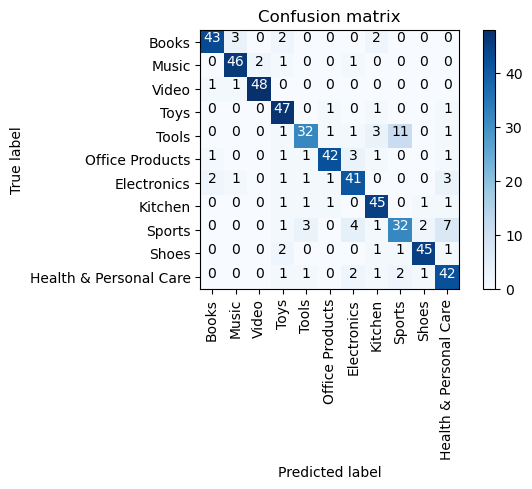

In [96]:
# compute the confusion matrix for best LR model
confusion_mtx_distilbert = confusion_matrix(distilbert_labels, distilbert_preds)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_distilbert,
            classes = classes)

In [74]:
# find false positive
false_positive_reviews_distilbert = []
for i in range(550):
    id = distilbert_res_corr[i]['Id']
    if distilbert_res_corr[i]['pred'] == 'Sports' and df.query(f'Id == {id}')['product_category'].item() == 'Tools':
        false_positive_reviews_distilbert.append(df.query(f'Id == {id}')['review_body'].item())
        
false_positive_reviews_distilbert

["Big beefy knife, thick blade! Takes an edge well, haven't used it enough to see if it will hold up.",
 'A new direction in knife making.....a knife that gives the common man, trust, confidence,  value, quality and does what Shrade says it will do.........if you can find a better knife for the money....buy it!......Thank you Schrade',
 "Probably the best knife for the money! The quality of the knife if not the same, exceeds better than any high price knife! From the 1/4 inch high carbon steel thick blade that's runs from tip all the way to the back of handle, style, and shape you'll be amaze! Anyone who purchase this knife will not be disappointed! I love this knife!! This Extreme survival knife is extremely recommend it!! .. See any YouTube videos for it's performance!",
 "it comes well packaged in a quality box.its larger than i expected.it comes extremely sharp.its not what id call elegant but more like a body builder on steroids!! to be fair its the first survival fixed blade i ha

### fewshot fine-tuning on electra

In [5]:
# create embedding
tokenizer = AutoTokenizer.from_pretrained("google/electra-base-discriminator")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, add_special_tokens=True, max_length=512)
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/550 [00:00<?, ? examples/s]

In [6]:
# create model
model = AutoModelForSequenceClassification.from_pretrained(
   "google/electra-base-discriminator", num_labels=11, id2label=id2label, label2id=label2id
)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
training_args = TrainingArguments(
    output_dir="amazon_product_corr_models_electra",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps = 10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

trainer.train()

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.195600,1.029025,0.816364
2,0.261700,1.009429,0.827273
3,0.075700,0.950077,0.834545
4,0.085400,1.051638,0.832727
5,0.004900,0.985456,0.847273


Checkpoint destination directory amazon_product_corr_models_electra/checkpoint-104 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory amazon_product_corr_models_electra/checkpoint-208 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory amazon_product_corr_models_electra/checkpoint-312 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory amazon_product_corr_models_electra/checkpoint-416 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory amazon_product_corr_models_electra/checkpoint-520 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=520, training_loss=0.12327504954659022, metrics={'train_runtime': 173.467, 'train_samples_per_second': 47.559, 'train_steps_per_second': 2.998, 'total_flos': 1731195820833852.0, 'train_loss': 0.12327504954659022, 'epoch': 5.0})

### evaluation on electra

In [49]:
# load pretrained model
tokenizer_electra = AutoTokenizer.from_pretrained("google/electra-base-discriminator")
model_electra = AutoModelForSequenceClassification.from_pretrained(
    "amazon_product_corr_models_electra/checkpoint-520", num_labels=11, id2label=id2label, label2id=label2id
)

In [89]:
if not os.path.exists("./electra_eval_results_task2.json"):
    electra_res_corr, electra_correct_corr, electra_total_corr, electra_runtime_corr, electra_preds, electra_labels = pipeline_corr_eval_slm(tokenizer_electra, model_electra, test_dataset, id2label)
    with open("./electra_eval_results_task2.json", "w") as f:
        data = {}
        data['res_corr'] = electra_res_corr
        data['correct_corr'] = electra_correct_corr
        data['total_corr'] = electra_total_corr
        data['runtime_corr'] = electra_runtime_corr
        data['preds'] = electra_preds
        data['labels'] = electra_labels
        json.dump(data,f)
        print('=> save results to electra_eval_results_task2.json')
else:
    with open("./electra_eval_results_task2.json", "r") as f:
        data = json.load(f)
        electra_res_corr = data['res_corr']
        electra_correct_corr = data['correct_corr']
        electra_total_corr = data['total_corr']
        electra_runtime_corr = data['runtime_corr']
        electra_preds = data['preds']
        electra_labels = data['labels']
        print('=> load results from electra_eval_results_task2.json')

=> load results from FlanT5_eval_results_task2.json


In [51]:
# calculate the accuracy
for key,val in id2label.items():
    print(f'==> {val} Accuracy: {electra_correct_corr[int(key)]/electra_total_corr[int(key)]}')
print(f'==> Total Accuracy: {np.sum(electra_correct_corr) / np.sum(electra_total_corr)}')
print(f'==> Total Runtime: {electra_runtime_corr}')

==> Books Accuracy: 0.9
==> Music Accuracy: 0.9
==> Video Accuracy: 0.94
==> Toys Accuracy: 0.9
==> Tools Accuracy: 0.62
==> Office Products Accuracy: 0.82
==> Electronics Accuracy: 0.88
==> Kitchen Accuracy: 0.92
==> Sports Accuracy: 0.7
==> Shoes Accuracy: 0.9
==> Health & Personal Care Accuracy: 0.84
==> Total Accuracy: 0.8472727272727273
==> Total Runtime: 48.8053925037384


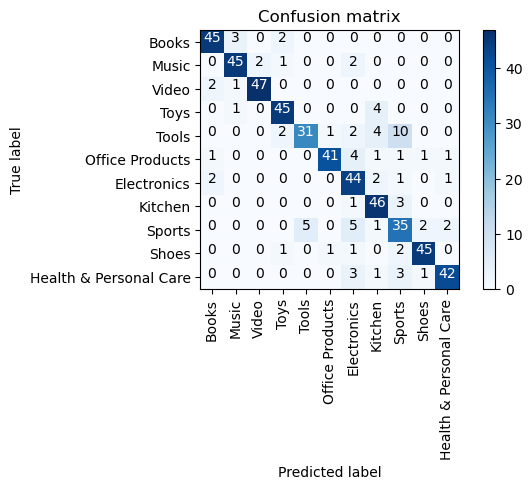

In [91]:
# compute the confusion matrix for best LR model
confusion_mtx_electra = confusion_matrix(electra_labels, electra_preds)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_electra,
            classes = classes)

In [75]:
# find false positive
false_positive_reviews_electra = []
for i in range(550):
    id = electra_res_corr[i]['Id']
    if electra_res_corr[i]['pred'] == 'Sports' and df.query(f'Id == {id}')['product_category'].item() == 'Tools':
        false_positive_reviews_electra.append(df.query(f'Id == {id}')['review_body'].item())
        
false_positive_reviews_electra

["Big beefy knife, thick blade! Takes an edge well, haven't used it enough to see if it will hold up.",
 'A new direction in knife making.....a knife that gives the common man, trust, confidence,  value, quality and does what Shrade says it will do.........if you can find a better knife for the money....buy it!......Thank you Schrade',
 "Probably the best knife for the money! The quality of the knife if not the same, exceeds better than any high price knife! From the 1/4 inch high carbon steel thick blade that's runs from tip all the way to the back of handle, style, and shape you'll be amaze! Anyone who purchase this knife will not be disappointed! I love this knife!! This Extreme survival knife is extremely recommend it!! .. See any YouTube videos for it's performance!",
 "it comes well packaged in a quality box.its larger than i expected.it comes extremely sharp.its not what id call elegant but more like a body builder on steroids!! to be fair its the first survival fixed blade i ha

## LLM correlation analysis

### define LLM correlation anaylsis pipeline

In [14]:
def pipeline_corr_eval_llm(pipe, data, template, label2id):
  res_dict = {}
  correct = [0 for _ in range(11)]
  total = [0 for _ in range(11)]
  preds = []
  labels = []

  start_time = time.time()
  for i, row in tqdm(enumerate(data), total=len(data)):
      text = row['text']
      label = int(row['label'])
      prompt = template.format(text = text)
      result = pipe(prompt)[0]
      pred = int(label2id[result['generated_text']])
      result['Id'] = row['Id']
      res_dict[i] = {'Id': row['Id'], 'pred':result['generated_text']}
      preds.append(pred)
      labels.append(label)
      total[label] += 1
      if pred == label:
          correct[label] += 1
  
  end_time = time.time()
  runtime = end_time - start_time
  return res_dict, correct, total, runtime, preds, labels

### zero-shot inference on FLAN-T5

In [11]:
task_name = 'text classification'
label_space = ["Books", "Music", "Video", "Toys", "Tools", "Office Products", "Electronics", "Kitchen", "Sports", "Shoes", "Health & Personal Care"]
task_definition = f'Given the sentence, assign a product label from {label_space}'
output_format = "Return label only without any other text."

template = f"Please perform {task_name} task.\n{task_definition}\n{output_format}\nSentence:\n" + "{text}."

In [55]:
# Flan-T5
pipeFlanT5 = pipeline("text2text-generation", model="google/flan-t5-xxl", device=0)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [57]:
example = test_dataset[100]['text']
start_time = time.time()
prompt = template.format(text = example)
output = pipeFlanT5(prompt)
end_time = time.time()
print(f'input : {example}')
print(f'output : {output}')
print(f'runtime : {end_time-start_time}')

/home/xiao.yang3/.conda/envs/llama2/lib/python3.11/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


input : The Film Follows The Adventures of Anastasia, a Rusin Princess Who Lost Her Memery Years Ago As A Young Girl. On Her Way To Paris To See Her Gandma, She Bumps Into Demetrie and Vlad Who Help On Her Journey. Meanwhile, Evil Velian Russputain and Sidekick Bartok The Bat Try To Distroy Anastasia From Knowing Who She Was Years Ago.    ANASTASIA is Not Anwhere Near Don Bluth's Best Film Made, But This is Still One of The Best Animated Films Made.    The Animation Even Being 2D Animation, is Absolutly Realistic.    The Voice Talents Are Great Featuring Meg Ryan as Anastasia, John Cussack (From MARTIAN CHILD) as Demitrie, Christopher Lloyd (From BACK TO THE FUTURE) as Rusputian, Hank Arazaria (From THE SIMPSONS) as The Sidekick Bartok, Among Others.    The Directors Don Bluth (THE SECRET OF NIMH) and Gary Goldman (TITAN A.E.) Have Made A Great Film Though It's Not for the Whole Family (Violene and Suspence), Thay've Made One Great Film That Will Be Timeless For Generations To Come.   

In [25]:
if not os.path.exists("./FlanT5_eval_results_task2.json"):
    FlanT5_res_corr, FlanT5_correct_corr, FlanT5_total_corr, FlanT5_runtime_corr, FlanT5_preds, FlanT5_labels = pipeline_corr_eval_llm(pipeFlanT5, test_dataset, template, label2id)
    with open("./FlanT5_eval_results_task2.json", "w") as f:
        data = {}
        data['res_corr'] = FlanT5_res_corr
        data['correct_corr'] = FlanT5_correct_corr
        data['total_corr'] = FlanT5_total_corr
        data['runtime_corr'] = FlanT5_runtime_corr
        data['preds'] = FlanT5_preds
        data['labels'] = FlanT5_labels
        json.dump(data,f)
    print('=> save results to FlanT5_eval_results_task2.json')
else:
    with open("./FlanT5_eval_results_task2.json", "r") as f:
        data = json.load(f)
        FlanT5_res_corr = data['res_corr']
        FlanT5_correct_corr = data['correct_corr']
        FlanT5_total_corr = data['total_corr']
        FlanT5_runtime_corr = data['runtime_corr']
        FlanT5_preds = data['preds']
        FlanT5_labels = data['labels']
    print('=> load results from FlanT5_eval_results_task2.json')

=> load results from FlanT5_eval_results_task2.json


In [26]:
# calculate the accuracy
for key,val in id2label.items():
    print(f'==> {val} Accuracy: {FlanT5_correct_corr[int(key)]/FlanT5_total_corr[int(key)]}')
print(f'==> Total Accuracy: {np.sum(FlanT5_correct_corr) / np.sum(FlanT5_total_corr)}')
print(f'==> Total Runtime: {FlanT5_runtime_corr}')

==> Books Accuracy: 0.94
==> Music Accuracy: 0.96
==> Video Accuracy: 0.98
==> Toys Accuracy: 1.0
==> Tools Accuracy: 0.86
==> Office Products Accuracy: 0.3
==> Electronics Accuracy: 0.94
==> Kitchen Accuracy: 0.58
==> Sports Accuracy: 0.12
==> Shoes Accuracy: 0.94
==> Health & Personal Care Accuracy: 0.38
==> Total Accuracy: 0.7272727272727273
==> Total Runtime: 176.13426733016968


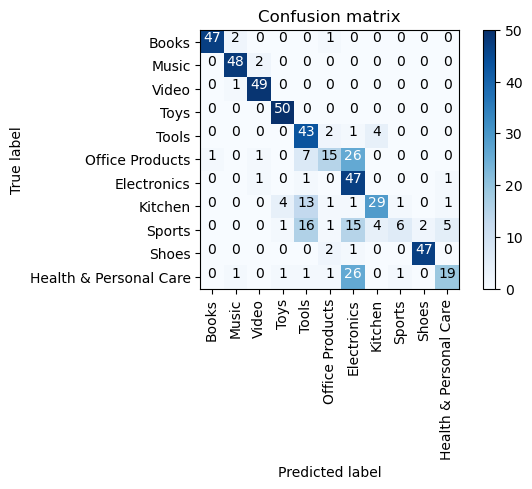

In [64]:
# compute the confusion matrix for best LR model
confusion_mtx_FlanT5 = confusion_matrix(FlanT5_labels, FlanT5_preds)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_FlanT5,
            classes = classes)

In [29]:
# find false positive
false_positive_reviews_FlanT5 = []
for i in range(550):
    id = FlanT5_res_corr[str(i)]['Id']
    if FlanT5_res_corr[str(i)]['pred'] == 'Tools' and df.query(f'Id == {id}')['product_category'].item() == 'Sports':
        false_positive_reviews_FlanT5.append(df.query(f'Id == {id}')['review_body'].item())
        
false_positive_reviews_FlanT5

['american made what else is needed nice hefty blade and shave the hair off your arm straight out of the box great knife for a great price the scabered that it comes with takes  some power to get it out but thats what you want when moving around wont accidently fall or get pulled out. this knife is made to work and will last a life time',
 "WOW, That was the first word out of my mouth when I held this knife. Everything about this knife is perfect the weight,the size,the thickness (it's thickier then a pry bar)and it's durability. Your just not going to break this knife. I love it!",
 'i just recieved my knife this morning and its incredibly sharp, I litterally shaved with it. i was slightly disapointed when i tested its tip and stabbed a 2x4.the tip dulled dramatically from what it had been, but its not bad and im still very impressed. when this weekend comes around itl be time to start testing it.<br /><br />Thank you for all your reviews everyone, you all helped me make my decision i

In [28]:
FlanT5_res_corr

{'0': {'Id': 1207687, 'pred': 'Books'},
 '1': {'Id': 5232282, 'pred': 'Books'},
 '2': {'Id': 706390, 'pred': 'Books'},
 '3': {'Id': 835109, 'pred': 'Books'},
 '4': {'Id': 197864, 'pred': 'Books'},
 '5': {'Id': 1571597, 'pred': 'Books'},
 '6': {'Id': 3805072, 'pred': 'Books'},
 '7': {'Id': 2338233, 'pred': 'Books'},
 '8': {'Id': 578343, 'pred': 'Books'},
 '9': {'Id': 4023378, 'pred': 'Books'},
 '10': {'Id': 4860953, 'pred': 'Books'},
 '11': {'Id': 199896, 'pred': 'Books'},
 '12': {'Id': 5582229, 'pred': 'Books'},
 '13': {'Id': 664029, 'pred': 'Books'},
 '14': {'Id': 1183452, 'pred': 'Books'},
 '15': {'Id': 582698, 'pred': 'Books'},
 '16': {'Id': 3576148, 'pred': 'Books'},
 '17': {'Id': 487121, 'pred': 'Books'},
 '18': {'Id': 2751775, 'pred': 'Books'},
 '19': {'Id': 1864520, 'pred': 'Books'},
 '20': {'Id': 3219825, 'pred': 'Books'},
 '21': {'Id': 5997446, 'pred': 'Books'},
 '22': {'Id': 3694255, 'pred': 'Books'},
 '23': {'Id': 849478, 'pred': 'Books'},
 '24': {'Id': 5186274, 'pred': 'Off

### zero-shot inference on FLAN-UL2

In [9]:
# flan-UL2
pipeFlanUL2 = pipeline("text2text-generation", model="google/flan-ul2", device=0)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [12]:
example = test_dataset[100]['text']
start_time = time.time()
prompt = template.format(text = example)
output = pipeFlanUL2(prompt)
end_time = time.time()
print(f'input : {example}')
print(f'output : {output}')
print(f'runtime : {end_time-start_time}')

/home/xiao.yang3/.conda/envs/llama2/lib/python3.11/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


input : The Film Follows The Adventures of Anastasia, a Rusin Princess Who Lost Her Memery Years Ago As A Young Girl. On Her Way To Paris To See Her Gandma, She Bumps Into Demetrie and Vlad Who Help On Her Journey. Meanwhile, Evil Velian Russputain and Sidekick Bartok The Bat Try To Distroy Anastasia From Knowing Who She Was Years Ago.    ANASTASIA is Not Anwhere Near Don Bluth's Best Film Made, But This is Still One of The Best Animated Films Made.    The Animation Even Being 2D Animation, is Absolutly Realistic.    The Voice Talents Are Great Featuring Meg Ryan as Anastasia, John Cussack (From MARTIAN CHILD) as Demitrie, Christopher Lloyd (From BACK TO THE FUTURE) as Rusputian, Hank Arazaria (From THE SIMPSONS) as The Sidekick Bartok, Among Others.    The Directors Don Bluth (THE SECRET OF NIMH) and Gary Goldman (TITAN A.E.) Have Made A Great Film Though It's Not for the Whole Family (Violene and Suspence), Thay've Made One Great Film That Will Be Timeless For Generations To Come.   

In [16]:
if not os.path.exists("./FlanUL2_eval_results_task2.json"): 
    FlanUL2_res_corr, FlanUL2_correct_corr, FlanUL2_total_corr, FlanUL2_runtime_corr, FlanUL2_preds, FlanUL2_labels = pipeline_corr_eval_llm(pipeFlanUL2, test_dataset, template, label2id)
    with open("./FlanUL2_eval_results_task2.json", "w") as f:
        data = {}
        data['res_corr'] = FlanUL2_res_corr
        data['correct_corr'] = FlanUL2_correct_corr
        data['total_corr'] = FlanUL2_total_corr
        data['runtime_corr'] = FlanUL2_runtime_corr
        data['preds'] = FlanUL2_preds
        data['labels'] = FlanUL2_labels
        json.dump(data,f)
    print('=> save results to FlanUL2_eval_results_task2.json')
else:
    with open("./FlanUL2_eval_results_task2.json", "r") as f:
        data = json.load(f)
        FlanUL2_res_corr = data['res_corr']
        FlanUL2_correct_corr = data['correct_corr']
        FlanUL2_total_corr = data['total_corr']
        FlanUL2_runtime_corr = data['runtime_corr']
        FlanUL2_preds = data['preds']
        FlanUL2_labels = data['labels']
    print('=> load results from FlanUL2_eval_results_task2.json')

NameError: name 'os' is not defined

In [19]:
# calculate the accuracy
for key,val in id2label.items():
    print(f'==> {val} Accuracy: {FlanUL2_correct_corr[int(key)]/FlanUL2_total_corr[int(key)]}')
print(f'==> Total Accuracy: {np.sum(FlanUL2_correct_corr) / np.sum(FlanUL2_total_corr)}')
print(f'==> Total Runtime: {FlanUL2_runtime_corr}')

==> Books Accuracy: 0.96
==> Music Accuracy: 1.0
==> Video Accuracy: 0.98
==> Toys Accuracy: 0.98
==> Tools Accuracy: 0.8
==> Office Products Accuracy: 0.5
==> Electronics Accuracy: 0.96
==> Kitchen Accuracy: 0.6
==> Sports Accuracy: 0.2
==> Shoes Accuracy: 0.96
==> Health & Personal Care Accuracy: 0.48
==> Total Accuracy: 0.7654545454545455
==> Total Runtime: 268.7550759315491


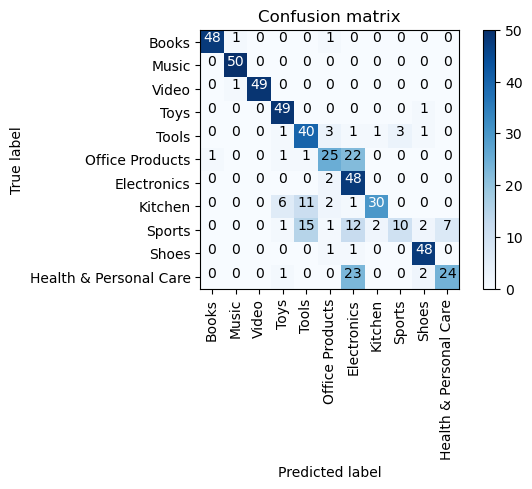

In [20]:
# compute the confusion matrix for best LR model
confusion_mtx_FlanUL2 = confusion_matrix(FlanUL2_labels, FlanUL2_preds)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx_FlanUL2,
            classes = classes)

In [21]:
# find false positive
false_positive_reviews_FlanUL2 = []
for i in range(550):
    id = FlanUL2_res_corr[i]['Id']
    if FlanUL2_res_corr[i]['pred'] == 'Electronics' and df.query(f'Id == {id}')['product_category'].item() == 'Health & Personal Care':
        false_positive_reviews_FlanUL2.append(df.query(f'Id == {id}')['review_body'].item())
        
false_positive_reviews_FlanUL2

['This item was purchased by me in an effort to see if these types of hearing devices could help.  This one worked very well, but was designed to listen to birds and bird watching.  I returned the item, not because it was defective, but to purchase one made for special hearing aids.',
 "I worked and worked and worked to try and get it to focus on my TV but was never successful. At standard viewing distance you can only see part of the screen and even that is not comfortable viewing. What a waste of money! You would think a German product would have better engineering than this. I hardly return anything but I'm going to try and get my money back on this one.<br /><br />Rick<br /><br />Edit 9/1/13: The product did not work for me but I am PLEASED with the seller. The refund process was simple and I received my refund promptly.<br /><br />Rick",
 "Connectivity not as clean as I expected.  I was looking for a device to connect to Microsoft HealthVault, so far I've been unable to connect. T

# Visulization

## Task1


|Model|DistilBert|Electra|FlanT5|FlanUL2|
|-|-|-|-|-|
|Accuracy|0.8418|**0.8472**|0.727|0.765|
|Runtime(GPU)/s|**23.87**|43.80|173.13|286.75|

In [10]:
import matplotlib.pyplot as plt

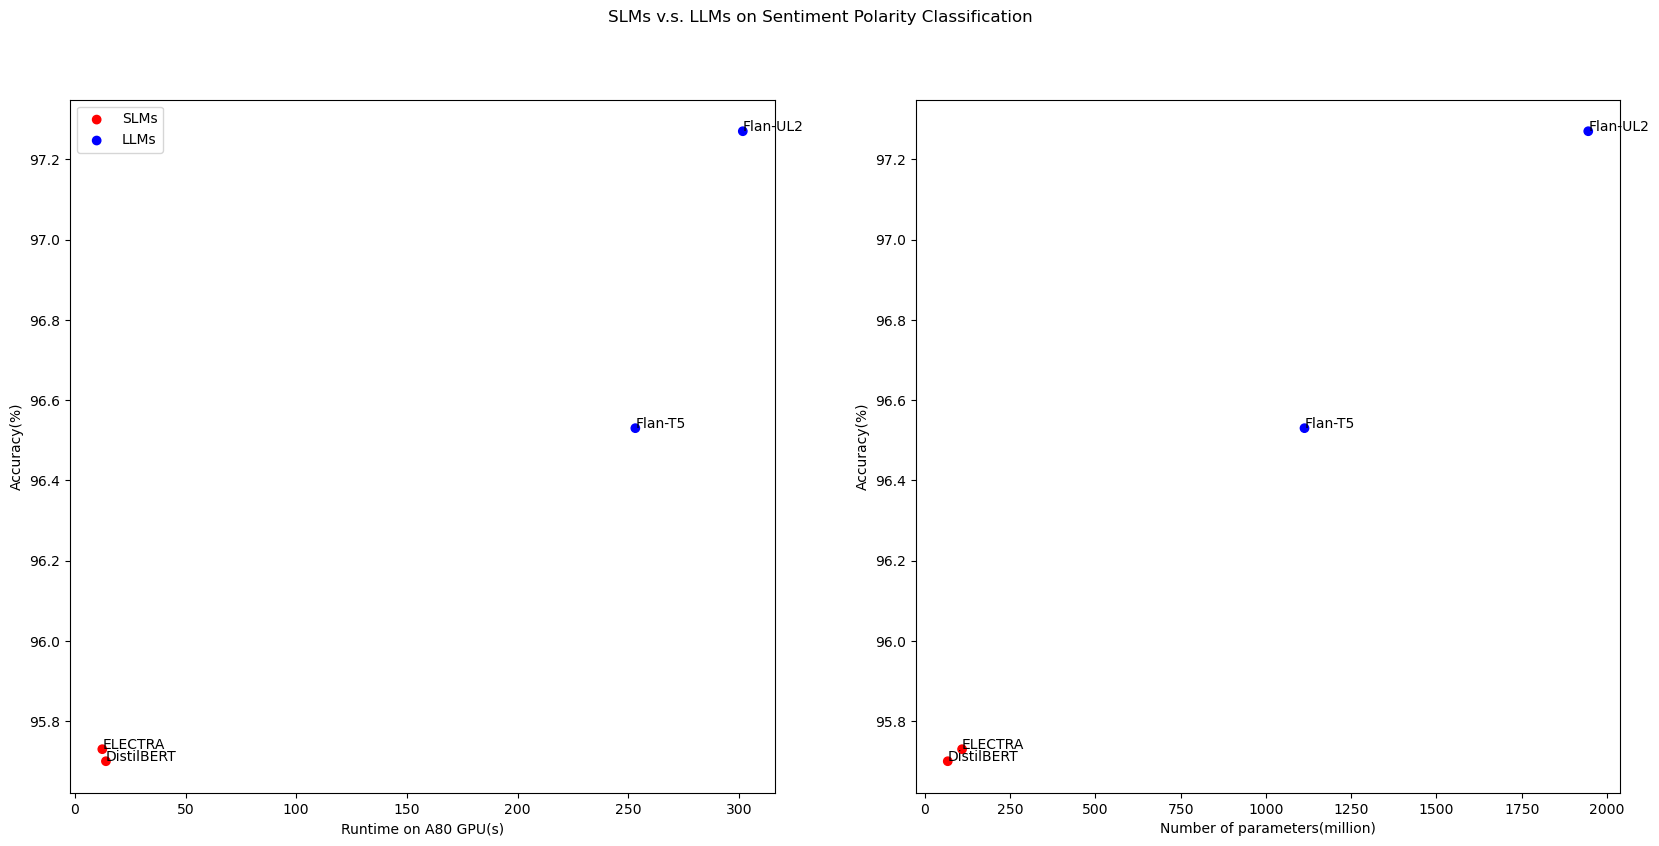

In [46]:
# Sample data
acc = [95.7, 95.73, 96.53, 97.27]
runtime = [14.03, 12.39, 253.22, 301.77]
parameters = [67, 109, 1113, 1945]
labels = ['DistilBERT', 'ELECTRA', 'Flan-T5', 'Flan-UL2']
colors = ['red', 'red', 'blue', 'blue']

fig, ax = plt.subplots(1, 2, figsize=(15,7))


ax[0].scatter(runtime[:2], acc[:2], c = colors[:2], label='SLMs')
ax[0].scatter(runtime[2:], acc[2:], c = colors[2:], label='LLMs')
# Annotate each point
for i, label in enumerate(labels):
    ax[0].annotate(label, (runtime[i], acc[i]))

# Add labels and title
ax[0].set_xlabel('Runtime on A80 GPU(s)')
ax[0].set_ylabel('Accuracy(%)')
ax[0].legend()




ax[1].scatter(parameters[:2], acc[:2], c = colors[:2], label='SLMs')
ax[1].scatter(parameters[2:], acc[2:], c = colors[2:], label='LLMs')
# Annotate each point
for i, label in enumerate(labels):
    ax[1].annotate(label, (parameters[i], acc[i]))

# Add labels and title
ax[1].set_xlabel('Number of parameters(million)')
ax[1].set_ylabel('Accuracy(%)')
ax[1].legend
fig.suptitle('SLMs v.s. LLMs on Sentiment Polarity Classification')

# Show plot
plt.show()

## Task2

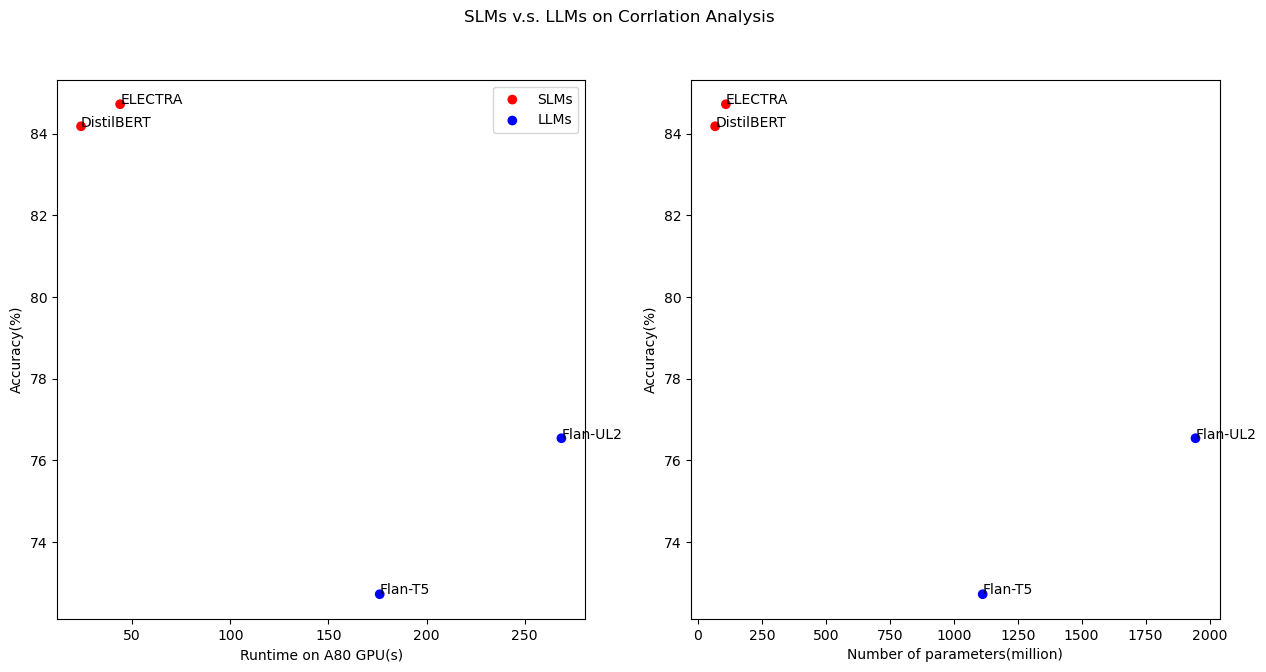

In [9]:
# Sample data
acc = [84.18, 84.72, 72.72, 76.54]
runtime = [23.87, 43.80, 176.13, 268.75]
parameters = [67, 109, 1113, 1945]
labels = ['DistilBERT', 'ELECTRA', 'Flan-T5', 'Flan-UL2']
colors = ['red', 'red', 'blue', 'blue']

fig, ax = plt.subplots(1, 2, figsize=(15,7))


ax[0].scatter(runtime[:2], acc[:2], c = colors[:2], label='SLMs')
ax[0].scatter(runtime[2:], acc[2:], c = colors[2:], label='LLMs')
# Annotate each point
for i, label in enumerate(labels):
    ax[0].annotate(label, (runtime[i], acc[i]))

# Add labels and title
ax[0].set_xlabel('Runtime on A80 GPU(s)')
ax[0].set_ylabel('Accuracy(%)')
ax[0].legend()




ax[1].scatter(parameters[:2], acc[:2], c = colors[:2], label='SLMs')
ax[1].scatter(parameters[2:], acc[2:], c = colors[2:], label='LLMs')
# Annotate each point
for i, label in enumerate(labels):
    ax[1].annotate(label, (parameters[i], acc[i]))

# Add labels and title
ax[1].set_xlabel('Number of parameters(million)')
ax[1].set_ylabel('Accuracy(%)')
ax[1].legend
fig.suptitle('SLMs v.s. LLMs on Corrlation Analysis')

# Show plot
plt.show()